In [2]:
import pandas as pd
import os
import numpy as np
from enum import Enum
import sys
import gc
from pprint import pprint
sys.path.append("../src")
from sklearn.base import TransformerMixin, BaseEstimator
import re

from config import data_dir
from data_loader import DataLoader, DatasetFilename
from tqdm import tqdm
from data.transformers import OneHotEncoderWithMemory

# auto reload all modules
%load_ext autoreload
%autoreload 2

In [3]:
DatasetFilename.__members__

mappingproxy({'APPLICATIONS': <DatasetFilename.APPLICATIONS: 'application_train.gzip'>,
              'BUREAU_BALANCE': <DatasetFilename.BUREAU_BALANCE: 'bureau_balance.gzip'>,
              'BUREAU': <DatasetFilename.BUREAU: 'bureau.gzip'>,
              'CREDIT_CARD_BALANCE': <DatasetFilename.CREDIT_CARD_BALANCE: 'credit_card_balance.gzip'>,
              'INSTALLMENTS_PAYMENTS': <DatasetFilename.INSTALLMENTS_PAYMENTS: 'installments_payments.gzip'>,
              'PREVIOUS_APPLICATIONS': <DatasetFilename.PREVIOUS_APPLICATIONS: 'previous_application.gzip'>,
              'CASH_BALANCE': <DatasetFilename.CASH_BALANCE: 'POS_CASH_balance.gzip'>})

In [4]:
data_dir() / DatasetFilename.from_name('applications')

PosixPath('/app/home-credit-risk/datasets/application_train.gzip')

In [5]:
data_io = DataLoader()

# Exploratory Data Analysis

In this notebook we want to understand what kind of data we have before approaching feature engineering.

* What information do the datasets contain
* Is there any missing data
* Investigating outliers (are they due to entry error?)
* Look at target variable
    * what is correlated with the target
    
At the end we want to know:
* how imbalanced is our data
* do we need to fill in / drop missing data
* do wee need to handle outliers
* restrict set of columns used in feature engineering

In [6]:
#data_io.load_all()

for d in tqdm(['applications']):
    data_io.load_dataset(d)

  0%|                                                                         | 0/1 [00:00<?, ?it/s]2022-05-11 22:55:42 logger [214] DEBUG {'process': 'load_dataset', 'message': 'Started.', 'args': {}}
2022-05-11 22:55:44 logger [214] DEBUG {'process': 'load_dataset', 'message': 'Success.', 'elapsed_seconds': 2.7992}
100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


In [7]:
data_io.list_loaded()

['applications']

In [8]:
data_io['applications']

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,cash loans,m,n,y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,cash loans,f,n,n,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,revolving loans,m,y,y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,cash loans,f,n,y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,cash loans,m,n,y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,cash loans,m,n,n,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,cash loans,f,n,y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,cash loans,f,n,y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,cash loans,f,n,y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
data_io['applications'].sk_id_curr.nunique()

307511

In [17]:
[col for col in data_io['applications'].columns if 'days' in col]

['days_birth',
 'days_employed',
 'days_registration',
 'days_id_publish',
 'days_last_phone_change']

## Dataset: Applications

In [7]:
data_io.describe_columns('applications')

,row,description
0,sk_id_curr,ID of loan in our sample
1,target,Target variable (1 - client with payment diffi...
2,name_contract_type,Identification if loan is cash or revolving
3,code_gender,Gender of the client
4,flag_own_car,Flag if the client owns a car
...,...,...
117,amt_req_credit_bureau_day,Number of enquiries to Credit Bureau about the...
118,amt_req_credit_bureau_week,Number of enquiries to Credit Bureau about the...
119,amt_req_credit_bureau_mon,Number of enquiries to Credit Bureau about the...
120,amt_req_credit_bureau_qrt,Number of enquiries to Credit Bureau about the...


## Target
TARGET :  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

We have just about 8% defaults. This is a very imbalanced dataset, which is normal for credit risk field. You do not expect to have a high number of defaults, making it harder to train models.

However, 8% is not that severe for such dataset, it is actually very high. You often see less than 1% defaults. 

0.08072881945686496


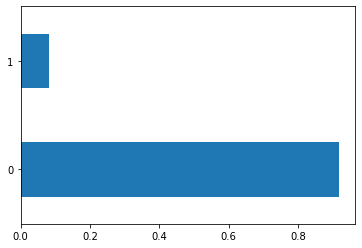

In [8]:
n_apps = data_io['applications'].shape[0]
(data_io['applications'].target.value_counts() / n_apps).plot.barh()

print(data_io['applications'].target.sum() / n_apps)

In [9]:
# making sure load ID is unique pro application
data_io['applications'].name_contract_type.unique()

array(['cash loans', 'revolving loans'], dtype=object)

# Applications Data

In [10]:
class TargetData:
    REQUIRED_DATASETS = ['applications']
    
    def __init__(self, data_io:DataIO):
        self.data_io = data_io
    
    def generate_target(self) -> pd.DataFrame:
        df = self.data_io['applications'].copy()
        self.dataset = df[['sk_id_curr', 'target']]
        
        return self.dataset
    
TargetData(data_io=data_io).generate_target().head(1)

,sk_id_curr,target
0,100002,1


In [11]:
class SkipAggregator:
    """Skip aggregations."""
    
    REQUIRED_DATASETS = list()
    
    @classmethod
    def name(cls):
        return 'skipper'
    
    
    def aggregate(self, data_io, output_dataset_name:str):
        return data_io[output_dataset_name]

## Idea: Aggregate -> Transform + New features (not result of aggregation)
Attr: `features_` - all that is not index

`FeatureGenerator` = `DataAggregator` + `TransformerStack`

`DataAggregator`: takes in `DataIO` object (with dataset `dict`), returns a _single_ dataset.
`TransformerStack`: takes in a single `pd.DataFrame`, returns also a single `pd.DataFrame`.

`ApplicationFeatures` = `SkipAggregator` + `Stack([OneHotEncoderWithMemory, ])`

FeatureGenerator:
* applied data aggregator to combine required daatsets into one
* processes aggregated columns (single column)
* Adds new features that combine columns (several columns)

In [12]:
class ApplicationFeatures:
    
    BIN_FEATURES = ['code_gender', 'flag_own_car', 'flag_own_realty']
    REQUIRED_DATASETS = ['applications']
    
    def __init__(self, data_io:DataIO):
        self.data_io = data_io
    
    @classmethod
    def preprocess(cls, df: pd.DataFrame) -> pd.DataFrame:
        # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
        df.drop('target', axis=1, inplace=True)
        df = df[df['code_gender'] != 'XNA']

        # Categorical features with Binary encode (0 or 1; two categories)
        for bin_feature in cls.BIN_FEATURES:
            df.loc[:, bin_feature], uniques = pd.factorize(df.loc[:, bin_feature])
        # Categorical features with One-Hot encode
        encoder = OneHotEncoderWithMemory(nan_category=False)
        df = encoder.fit_transform(df)
        
        # NaN values for days_employed: 365.243 -> nan
        df['days_employed'].replace(365243, np.nan, inplace= True)
        
        return df
    
    @staticmethod
    def add_new_features(df):
         # Some simple new features (percentages)
        df['days_employed_perc'] = df['days_employed'] / df['days_birth']
        df['income_credit_perc'] = df['amt_income_total'] / df['amt_credit']
        df['income_per_person'] = df['amt_income_total'] / df['cnt_fam_members']
        df['annuity_income_perc'] = df['amt_annuity'] / df['amt_income_total']
        df['payment_rate'] = df['amt_annuity'] / df['amt_credit']
        return df
    
    def generate_features(self):
        df = self.data_io['applications'].copy()
        print("Samples: {}".format(len(df)))
        
        df = ApplicationFeatures.preprocess(df)
        df = ApplicationFeatures.add_new_features(df)
        
        gc.collect()
        
        self.dataset = df
        
        return df

In [15]:
app_f = ApplicationFeatures(data_io=data_io)
app_f.REQUIRED_DATASETS

['applications']

In [16]:
app_f.generate_features().head(1)

Samples: 307511


,sk_id_curr,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,...,wallsmaterial_mode_panel,"wallsmaterial_mode_stone, brick",wallsmaterial_mode_wooden,emergencystate_mode_no,emergencystate_mode_yes,days_employed_perc,income_credit_perc,income_per_person,annuity_income_perc,payment_rate
0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749


In [17]:
app_f.dataset.columns

Index(['sk_id_curr', 'code_gender', 'flag_own_car', 'flag_own_realty',
       'cnt_children', 'amt_income_total', 'amt_credit', 'amt_annuity',
       'amt_goods_price', 'region_population_relative',
       ...
       'wallsmaterial_mode_panel', 'wallsmaterial_mode_stone, brick',
       'wallsmaterial_mode_wooden', 'emergencystate_mode_no',
       'emergencystate_mode_yes', 'days_employed_perc', 'income_credit_perc',
       'income_per_person', 'annuity_income_perc', 'payment_rate'],
      dtype='object', length=246)

In [39]:
class TrainingData:
    
    def __init__(self, data_io: DataIO,
                       target: TargetData,
                       app_data: ApplicationFeatures,
                       merge_on='sk_id_curr'):
        self.target = target(data_io=data_io)
        self.app_data = app_data(data_io=data_io)
        self.merge_on = merge_on
        
    def generate_training_dataset(self):
        self.target.generate_target()
        self.app_data.generate_features()
        
        df = self.target.dataset.merge(self.app_data.dataset, how='left', on=self.merge_on)
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        self.training_data = df
                
        return df

In [40]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [41]:
# full scripts

data_generator = TrainingData(data_io=data_io,
                              target=TargetData,
                              app_data=ApplicationFeatures,
                              merge_on='sk_id_curr')

data = data_generator.generate_training_dataset()

# split into X and y
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# train & eval
estimator = LGBMClassifier()
estimator.fit(X_train, y_train)
preds = estimator.predict(X_test)
# scores = cross_val_score(LGBMClassifier(), X, y, cv=5)
eval_results = pd.DataFrame({'preds': preds, 'actuals': y_test})

Samples: 307511


In [47]:
recall_score(y_test, preds)

0.020164499867338818

In [48]:
precision_score(y_test, preds)

0.5135135135135135

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay, RocCurveDisplay

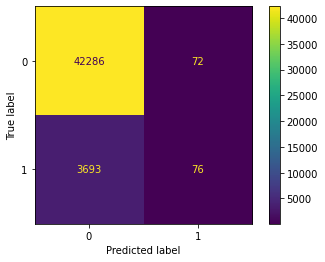

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, preds)

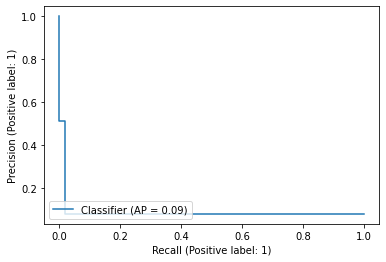

In [50]:
PrecisionRecallDisplay.from_predictions(y_test, preds)

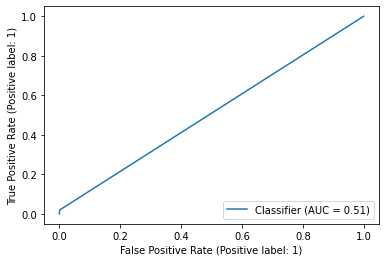

In [52]:
RocCurveDisplay.from_predictions(y_test, preds)

# After training

* save model
* save eval results

Later: model versioning

Create a model folder (version/timestamp)
Save model (joblib) and eval_results dir with plots

In [55]:
class Estimator:
    
    def __init__(self):
        self.model = None
        
    @classmethod
    def from_params(cls, params=dict()):
        return LGBMClassifier(**params)
    
    def serialize(self, filename:str='model_jlib'):
        joblib.dump(self.model , filename)
        
    def load(self, filename:str='model_jlib'):
        model = joblib.load(filename)
        return model

In [ ]:
MODEL_DIR = 'models'

SAVE_DIR = 'models'

In [54]:
import joblib

In [ ]:
joblib.dump(model , 'model_jlib')

## Bureau

In [60]:
data_io['bureau']

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,consumer credit,-131,NaN
1,215354,5714463,active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,credit card,-20,NaN
2,215354,5714464,active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,consumer credit,-16,NaN
3,215354,5714465,active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,credit card,-16,NaN
4,215354,5714466,active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,microloan,-19,NaN
1716424,100044,5057754,closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,consumer credit,-2493,NaN
1716425,100044,5057762,closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,consumer credit,-967,NaN
1716426,246829,5057770,closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,consumer credit,-1508,NaN


<AxesSubplot:xlabel='credit_type'>

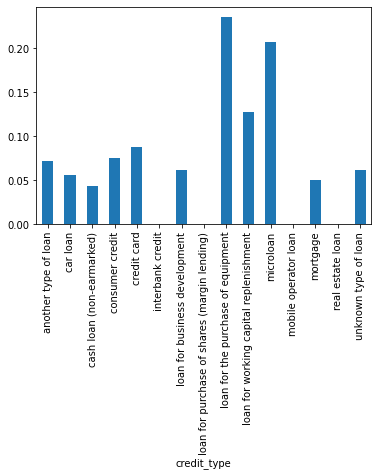

In [69]:
data_io['applications'][['sk_id_curr', 'target']]\
    .merge(data_io['bureau'][['sk_id_curr', 'credit_type']], on='sk_id_curr', how='left')\
    .groupby('credit_type').mean().target.plot.bar()

In [62]:
encoder1 = OneHotEncoderWithMemory(nan_category=False)
bureau = encoder1.fit_transform(data_io['bureau'])
bureau_cat = encoder1.encoded_columns_

encoder2 = OneHotEncoderWithMemory(nan_category=False)
bb = encoder2.fit_transform(data_io['bureau_balance'])
bb_cat = encoder2.encoded_columns_

In [63]:
bureau

,sk_id_curr,sk_id_bureau,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,...,credit_type_interbank credit,credit_type_loan for business development,credit_type_loan for purchase of shares (margin lending),credit_type_loan for the purchase of equipment,credit_type_loan for working capital replenishment,credit_type_microloan,credit_type_mobile operator loan,credit_type_mortgage,credit_type_real estate loan,credit_type_unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,...,0,0,0,0,0,1,0,0,0,0
1716424,100044,5057754,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,...,0,0,0,0,0,0,0,0,0,0
1716425,100044,5057762,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1716426,246829,5057770,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
a = 'credit_type_loan for purchase of shares (margin lending)'
a.replace(' ', '_')\
 .replace('-', '_')\
 .replace('(', '')\
 .replace(')', '')

clean_str = lambda s: s.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '')

def clean_column_names(df:pd.DataFrame) -> pd.DataFrame:
    df.columns = [clean_str(col) for col in df.columns]
    return df

In [49]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'months_balance': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('sk_id_bureau').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='sk_id_bureau')
bureau.drop(['sk_id_bureau'], axis=1, inplace= True)

In [50]:
#bureau = clean_column_names(bureau)
del bb, bb_agg
gc.collect()

0

In [51]:
bureau.columns

Index(['sk_id_curr', 'days_credit', 'credit_day_overdue',
       'days_credit_enddate', 'days_enddate_fact', 'amt_credit_max_overdue',
       'cnt_credit_prolong', 'amt_credit_sum', 'amt_credit_sum_debt',
       'amt_credit_sum_limit', 'amt_credit_sum_overdue', 'days_credit_update',
       'amt_annuity', 'credit_active_active', 'credit_active_bad debt',
       'credit_active_closed', 'credit_active_sold',
       'credit_currency_currency 1', 'credit_currency_currency 2',
       'credit_currency_currency 3', 'credit_currency_currency 4',
       'credit_type_another type of loan', 'credit_type_car loan',
       'credit_type_cash loan (non-earmarked)', 'credit_type_consumer credit',
       'credit_type_credit card', 'credit_type_interbank credit',
       'credit_type_loan for business development',
       'credit_type_loan for purchase of shares (margin lending)',
       'credit_type_loan for the purchase of equipment',
       'credit_type_loan for working capital replenishment',
       '

In [52]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'days_credit': ['min', 'max', 'mean', 'var'],
    'days_credit_enddate': ['min', 'max', 'mean'],
    'days_credit_update': ['mean'],
    'credit_day_overdue': ['max', 'mean'],
    'amt_credit_max_overdue': ['mean'],
    'amt_credit_sum': ['max', 'mean', 'sum'],
    'amt_credit_sum_debt': ['max', 'mean', 'sum'],
    'amt_credit_sum_overdue': ['mean'],
    'amt_credit_sum_limit': ['mean', 'sum'],
    'amt_annuity': ['max', 'mean'],
    'cnt_credit_prolong': ['sum'],
    'months_balance_min': ['min'],
    'months_balance_max': ['max'],
    'months_balance_size': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_mean"] = ['mean']

In [53]:
cat_aggregations

{'credit_active_active': ['mean'],
 'credit_active_bad debt': ['mean'],
 'credit_active_closed': ['mean'],
 'credit_active_sold': ['mean'],
 'credit_currency_currency 1': ['mean'],
 'credit_currency_currency 2': ['mean'],
 'credit_currency_currency 3': ['mean'],
 'credit_currency_currency 4': ['mean'],
 'credit_type_another type of loan': ['mean'],
 'credit_type_car loan': ['mean'],
 'credit_type_cash loan (non-earmarked)': ['mean'],
 'credit_type_consumer credit': ['mean'],
 'credit_type_credit card': ['mean'],
 'credit_type_interbank credit': ['mean'],
 'credit_type_loan for business development': ['mean'],
 'credit_type_loan for purchase of shares (margin lending)': ['mean'],
 'credit_type_loan for the purchase of equipment': ['mean'],
 'credit_type_loan for working capital replenishment': ['mean'],
 'credit_type_microloan': ['mean'],
 'credit_type_mobile operator loan': ['mean'],
 'credit_type_mortgage': ['mean'],
 'credit_type_real estate loan': ['mean'],
 'credit_type_unknown typ

In [54]:
bureau_agg = bureau.groupby('sk_id_curr').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['buro_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [55]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['credit_active_active'] == 1]
active_agg = active.groupby('sk_id_curr').agg(num_aggregations)
active_agg.columns = pd.Index(['active_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='sk_id_curr')
del active, active_agg
gc.collect()

0

In [56]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['credit_active_closed'] == 1]
closed_agg = closed.groupby('sk_id_curr').agg(num_aggregations)
closed_agg.columns = pd.Index(['closed_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='sk_id_curr')
del closed, closed_agg, bureau
gc.collect()

0

In [57]:
bureau_agg

,buro_days_credit_MIN,buro_days_credit_MAX,buro_days_credit_MEAN,buro_days_credit_VAR,buro_days_credit_enddate_MIN,buro_days_credit_enddate_MAX,buro_days_credit_enddate_MEAN,buro_days_credit_update_MEAN,buro_credit_day_overdue_MAX,buro_credit_day_overdue_MEAN,...,closed_amt_credit_sum_overdue_MEAN,closed_amt_credit_sum_limit_MEAN,closed_amt_credit_sum_limit_SUM,closed_amt_annuity_MAX,closed_amt_annuity_MEAN,closed_cnt_credit_prolong_SUM,closed_months_balance_min_MIN,closed_months_balance_max_MAX,closed_months_balance_size_MEAN,closed_months_balance_size_SUM
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [ ]:
class BureauFeatures:
    
    BIN_FEATURES = ['code_gender', 'flag_own_car', 'flag_own_realty']
    REQUIRED_DATASETS = ['bureau', 'bureau_balance']
    
    num_aggregations = {
        'days_credit': ['min', 'max', 'mean', 'var'],
        'days_credit_enddate': ['min', 'max', 'mean'],
        'days_credit_update': ['mean'],
        'credit_day_overdue': ['max', 'mean'],
        'amt_credit_max_overdue': ['mean'],
        'amt_credit_sum': ['max', 'mean', 'sum'],
        'amt_credit_sum_debt': ['max', 'mean', 'sum'],
        'amt_credit_sum_overdue': ['mean'],
        'amt_credit_sum_limit': ['mean', 'sum'],
        'amt_annuity': ['max', 'mean'],
        'cnt_credit_prolong': ['sum'],
        'months_balance_min': ['min'],
        'months_balance_max': ['max'],
        'months_balance_size': ['mean', 'sum']
    }
    
    def __init__(self, data_io):
        self.data_io = data_io
    
    def preprocess(self) -> tuple
        encoder1 = OneHotEncoderWithMemory(nan_category=False)
        bureau = encoder1.fit_transform(self.data_io['bureau'])
        self.bureau_cat_ = encoder1.encoded_columns_

        encoder2 = OneHotEncoderWithMemory(nan_category=False)
        bb = encoder2.fit_transform(self.data_io['bureau_balance'])
        self.bb_cat_ = encoder2.encoded_columns_
        
        return bureau, bb
    
    def aggregate(bureau, bb):
        # Bureau balance: Perform aggregations and merge with bureau.csv
        bb_aggregations = {'months_balance': ['min', 'max', 'size']}
        for col in bb_cat:
            bb_aggregations[col] = ['mean']
        bb_agg = bb.groupby('sk_id_bureau').agg(bb_aggregations)
        bb_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in bb_agg.columns.tolist()])
        bureau = bureau.join(bb_agg, how='left', on='sk_id_bureau')
        bureau.drop(['sk_id_bureau'], axis=1, inplace= True)
        
        del bb, bb_agg
        gc.collect()
        
        # Bureau and bureau_balance categorical features
        cat_aggregations = {}
        for cat in self.bureau_cat_: cat_aggregations[cat] = ['mean']
        for cat in self.bb_cat_: cat_aggregations[cat + "_mean"] = ['mean']
        
        bureau_agg = bureau.groupby('sk_id_curr').agg({**self.num_aggregations, **self.cat_aggregations})
        bureau_agg.columns = pd.Index(['buro_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
        
        # Bureau: Active credits - using only numerical aggregations
        active = bureau[bureau['credit_active_active'] == 1]
        active_agg = active.groupby('sk_id_curr').agg(num_aggregations)
        active_agg.columns = pd.Index(['active_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='sk_id_curr')
        del active, active_agg
        gc.collect()
        
        # Bureau: Closed credits - using only numerical aggregations
        closed = bureau[bureau['credit_active_closed'] == 1]
        closed_agg = closed.groupby('sk_id_curr').agg(num_aggregations)
        closed_agg.columns = pd.Index(['closed_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='sk_id_curr')
        del closed, closed_agg, bureau
        gc.collect()
        
        return bureau
    
    @staticmethod
    def add_new_features(df):
         # Some simple new features (percentages)
        df['days_employed_perc'] = df['days_employed'] / df['days_birth']
        df['income_credit_perc'] = df['amt_income_total'] / df['amt_credit']
        df['income_per_person'] = df['amt_income_total'] / df['cnt_fam_members']
        df['annuity_income_perc'] = df['amt_annuity'] / df['amt_income_total']
        df['payment_rate'] = df['amt_annuity'] / df['amt_credit']
        return df
    
    def generate_features(self):
        assert set(REQUIRED_DATASETS).issubset(set(self.data_io.list_loaded()))
        bureau, bb = self.preprocess(df)
        bureau = self.aggregate(bureau, bb)
        
        
        gc.collect()
        self.dataset = df
        
        return df

# Data Pipeline

`DatasetsFilename` - enum class to specify path for each filename

`DataIO` - Loading datasets by name. **Input**: falename (str), **output**: dict[pd.DataFrame]
* from file (parquet)
* from S3
* from SQL (S3 - Athena)

`DataAggregators` - **Input**: DataIO instance, **output**: single pd.DataFrame
`TrainingData` - **Input**: TargetDataAggregator, List[FeatureDataAggregator], **output**: single dataset
`Transformer`: **input**: pd.DataFrame, **output**: pd.DataFrame